In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import skimage
from skimage.transform import resize
import os
import torch
import glob
import random
import torch.nn as nn
import torch.optim as op
import torch.nn.functional as F
import datetime

from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms

In [ ]:
#To download from kaggle I had to get a json file by making an account
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download dataset
!kaggle datasets download grassknoted/asl-alphabet

100% 1.03G/1.03G [00:04<00:00, 327MB/s]
100% 1.03G/1.03G [00:04<00:00, 255MB/s]


In [ ]:
!unzip asl-alphabet.zip

Streaming output truncated to the last 5000 lines.
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1908.jpg  
  inflating: asl_alphabet_train/asl_alphabet_train/nothing/nothing1909.jpg  
  inflating: asl_alphabet_tr

In [ ]:
data_path = '/content/asl_alphabet_train/asl_alphabet_train'

#Borrowed this cell to import dataset from online (need to include reference)

train_transforms = transforms.Compose(
[transforms.Resize([64, 64]),
transforms.ToTensor()])

#transforms.Normalize(mean=[0.485, 0.456, 0.406],
#std=[0.229, 0.224, 0.225])


test_transforms = transforms.Compose(
[transforms.Resize([64, 64]),
transforms.ToTensor()])
 


#transforms.Normalize(mean=[0.485, 0.456, 0.406],
#std=[0.229, 0.224, 0.225])
 
data = datasets.ImageFolder(data_path, transform=train_transforms)
num_samples = len(data)
num_samples

87000

In [ ]:
test_size = 0.2
batch_size = 128
num_epoch = 10
learning_rate = 0.001
num_classes = 29

In [ ]:
#random seeding of the data
torch.manual_seed(1)
indices = torch.randperm(num_samples)

#splitting the data in training and validation sets
split = int(num_samples * test_size)
train_dataset = torch.utils.data.Subset(data, indices[split:])
val_dataset = torch.utils.data.Subset(data, indices[:split])

len(train_dataset), len(val_dataset)

(69600, 17400)

In [ ]:
#creating data loaders for both sets and establishing a "classes" to reference for webcam testing
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size, 
                                               shuffle=True)

val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)

classes = train_dataloader.dataset.dataset.classes

Ground truth Y


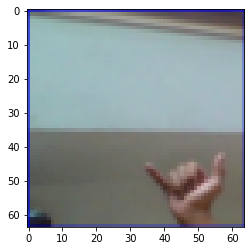

In [ ]:
for img, label in train_dataloader:
    print('Ground truth', classes[label[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    plt.show()
    break

In [ ]:
#Define ResNet blocks
class ResBlock(nn.Module):
  def __init__(self, n_chans):
    super(ResBlock, self).__init__()
    self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
    self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
    torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
    torch.nn.init.constant_(self.batch_norm.weight, 0.5)
    torch.nn.init.zeros_(self.batch_norm.bias)

  def forward(self, x):
    out = self.conv(x)
    out = self.batch_norm(out)
    out = torch.relu(out)
    return out + x

In [ ]:
#Define Model
#ResNet class with 10 resblocks
class ResNet_10(nn.Module):
  def __init__(self, n_chans1=32, n_blocks=10):
    super().__init__()
    self.n_chans1 = n_chans1
    self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
    self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
    self.fc1 = nn.Linear(16*16*n_chans1, 32)
    self.fc2 = nn.Linear(32, 29)

  def forward(self, x):
    out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
    out = self.resblocks(out)
    out = F.max_pool2d(out, 2)
    out = out.view(-1, 16*16*self.n_chans1)
    out = torch.relu(self.fc1(out))
    out = self.fc2(out)
    return out

In [ ]:
#Choose GPU if available
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
#Create training loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_dataloader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_dataloader:
          imgs = imgs.to(device=device)
          labels = labels.to(device=device)
          outputs = model(imgs)
          loss = loss_fn(outputs, labels)
 
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          loss_train += loss.item()

        if epoch == 1 or epoch % 1 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_dataloader)))

In [ ]:
#Compile model
model = ResNet_10(n_chans1=32, n_blocks=10).to(device=device)
optimizer = op.SGD(model.parameters(), momentum=0.9, lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
#Call training loop
training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_dataloader = train_dataloader,
)

2022-05-09 21:59:28.500670 Epoch 1, Training loss 2.4130938101340744
2022-05-09 22:01:02.456025 Epoch 2, Training loss 1.0572510611485033
2022-05-09 22:02:36.098727 Epoch 3, Training loss 0.603691069957088
2022-05-09 22:04:10.247492 Epoch 4, Training loss 0.3905152156127288
2022-05-09 22:05:44.116153 Epoch 5, Training loss 0.26657796957913565
2022-05-09 22:07:17.861920 Epoch 6, Training loss 0.17342737317770063
2022-05-09 22:08:52.192564 Epoch 7, Training loss 0.14299729071995793
2022-05-09 22:10:25.811130 Epoch 8, Training loss 0.09996251293855227
2022-05-09 22:11:59.394457 Epoch 9, Training loss 0.07268782960839898
2022-05-09 22:13:32.847696 Epoch 10, Training loss 0.05740529860828675


In [ ]:

#Create validate loop
def validate(model, train_dataloader, val_dataloader):
  for name, loader in [("train", train_dataloader), ("val", val_dataloader)]:
    correct = 0
    total = 0

    with torch.no_grad():
      for imgs, labels in loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim = 1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print("Accuracy {}: {:.2f}".format(name, correct / total))

In [ ]:
#Call validate loop
validate(model, train_dataloader, val_dataloader)

KeyboardInterrupt: ignored

In [ ]:
classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time


In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
 
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)


  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


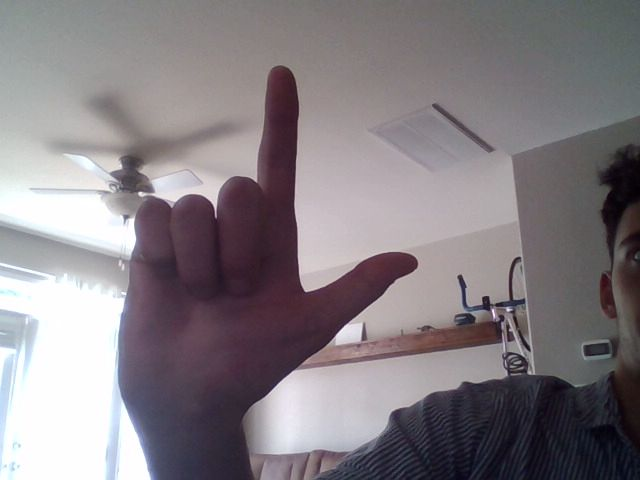

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


In [ ]:
#importing the image into google colab and showing it
from google.colab.patches import cv2_imshow
testImage = cv2.imread('/content/photo.jpg')

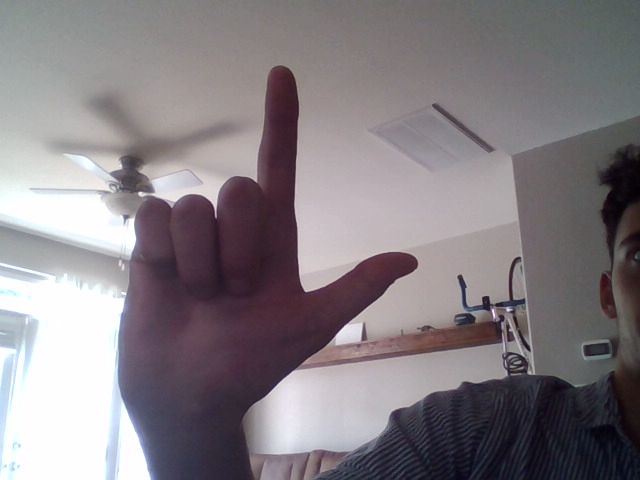

In [ ]:
cv2_imshow(testImage)

In [ ]:
#converting the webcam image into the proper format and then pre-processing it
#in the way that we have pre-processed the training and validation data
from PIL import Image
from matplotlib import cm
from PIL import Image
import numpy as np
new_im = Image.fromarray(testImage)

preprocess = transforms.Compose(
[transforms.Resize([64, 64]),
transforms.ToTensor()])
#transforms.Normalize(mean=[0.485, 0.456, 0.406],
          @std=[0.229, 0.224, 0.225])])

# Convert the image to PyTorch tensor
tensor = preprocess(new_im)

# print the converted image tensor
print(tensor)

tensor([[[ 0.3309,  0.3309,  0.3309,  ..., -0.5424, -0.5424, -0.5424],
         [ 0.3823,  0.3652,  0.3309,  ..., -0.5253, -0.5596, -0.5424],
         [ 0.4337,  0.4166,  0.3994,  ..., -0.4739, -0.4911, -0.5082],
         ...,
         [ 2.1804,  2.2147,  2.2489,  ..., -1.5699, -1.5870, -1.5870],
         [ 2.1804,  2.1462,  2.2318,  ..., -1.5699, -1.5870, -1.5870],
         [ 2.2318,  2.2147,  2.2318,  ..., -1.5357, -1.5699, -1.5357]],

        [[ 0.5028,  0.4853,  0.4853,  ..., -0.4076, -0.4076, -0.4426],
         [ 0.5378,  0.5378,  0.5378,  ..., -0.3901, -0.3901, -0.4076],
         [ 0.5728,  0.6078,  0.6078,  ..., -0.3375, -0.3725, -0.4076],
         ...,
         [ 2.3235,  2.3410,  2.3936,  ..., -1.6856, -1.7206, -1.7206],
         [ 2.2710,  2.2535,  2.3936,  ..., -1.6856, -1.7381, -1.6856],
         [ 2.3936,  2.3936,  2.4111,  ..., -1.6681, -1.7381, -1.6506]],

        [[ 0.5659,  0.5659,  0.6008,  ..., -0.3404, -0.3404, -0.3578],
         [ 0.6008,  0.6008,  0.6008,  ..., -0

In [ ]:
#Code used from HW0 to obtain our model's selected class
batch_t = torch.unsqueeze(tensor, 0)
batchDevice = batch_t.to(device)

In [ ]:
out = model(batchDevice)

In [ ]:
out

tensor([[  2.3001, -15.7049,  26.2312,  45.7413,  23.3940,  34.1637,   7.2572,
          -3.3725,  22.8701,  21.9506,   0.0874,  46.0122,  21.0611,  -3.5338,
          41.1686,  30.5671,  14.6134, -40.2762, -12.4785,  -1.1633, -25.3288,
         -10.8674,  -5.4373, -18.1673,  15.6057,   6.9500,   0.8325,  29.6856,
          -7.9284]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
#loading the 1000 labels, which are uploaded to the drive in this case
with open('/content/signLanguage_classes.txt') as f:
  labels = [line.strip() for line in f.readlines()]

In [ ]:
_, index = torch.max(out, 1)

In [ ]:
#using the index to find the highest scoring label
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
labels[index[0]], percentage[index[0]].item()

("11: 'L',", 56.478363037109375)

In [ ]:
#custom_test was a different test dataset which we didn't end up using later in the project
!unzip custom_test.zip

Archive:  custom_test.zip
   creating: custom_test/A/
  inflating: custom_test/A/1 - Copy.jpg  
  inflating: custom_test/A/105 - Copy.jpg  
  inflating: custom_test/A/116 - Copy.jpg  
  inflating: custom_test/A/118 - Copy.jpg  
  inflating: custom_test/A/2 - Copy.jpg  
  inflating: custom_test/A/205 - Copy.jpg  
  inflating: custom_test/A/224 - Copy.jpg  
  inflating: custom_test/A/305 - Copy.jpg  
  inflating: custom_test/A/315 - Copy.jpg  
  inflating: custom_test/A/354 - Copy.jpg  
  inflating: custom_test/A/357 - Copy.jpg  
  inflating: custom_test/A/36 - Copy.jpg  
  inflating: custom_test/A/369 - Copy.jpg  
  inflating: custom_test/A/377 - Copy.jpg  
  inflating: custom_test/A/39 - Copy.jpg  
  inflating: custom_test/A/435 - Copy.jpg  
  inflating: custom_test/A/455 - Copy.jpg  
  inflating: custom_test/A/457 - Copy.jpg  
  inflating: custom_test/A/484 - Copy.jpg  
  inflating: custom_test/A/486 - Copy.jpg  
  inflating: custom_test/A/497 - Copy.jpg  
  inflating: custom_test/A/5

In [ ]:
test_data_path = '/content/custom_test'

In [ ]:
test_data = datasets.ImageFolder(test_data_path, transform=test_transforms)
num_samples = len(test_data)
num_samples

2886

In [ ]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

Ground truth M


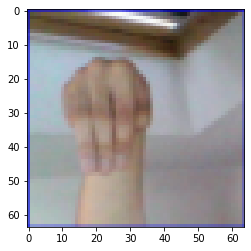

In [ ]:
for img, label in test_loader:
    print('Ground truth', classes[label[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    plt.show()
    break

In [ ]:
#Create validate loop
def validate(model, train_dataloader, val_dataloader):
  for name, loader in [("train", train_dataloader), ("val", val_dataloader), ("test", test_loader)]:
    correct = 0
    total = 0

    with torch.no_grad():
      for imgs, labels in loader:
        imgs = imgs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim = 1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

    print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_dataloader, val_dataloader)

#The peroformance of this test set is improved from the one we settled on
#however it was found later that it contained some images from our
#training set and was thus not used again.

Accuracy train: 0.99
Accuracy val: 0.98
Accuracy test: 0.44


In [ ]:
#This code is remnants from JULIA PONOMAREVA on Kaggle
#It provides a display that shows the guesses of your algorithm
#link to the original code: https://www.kaggle.com/code/julichitai/asl-alphabet-classification-using-pytorch
from pathlib import Path
from PIL import Image


test_data_path = Path('/content/asl_alphabet_test/asl_alphabet_test')


class ASLTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transforms=None):
        super().__init__()
        
        self.transforms = transforms
        self.imgs = sorted(list(Path(root_path).glob('*.jpg')))
        
    def __len__(self):
        return len(self.imgs)
            
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        
        label = img_path.parts[-1].split('_')[0]
        if self.transforms:
            img = self.transforms(img)
        
        return img, label

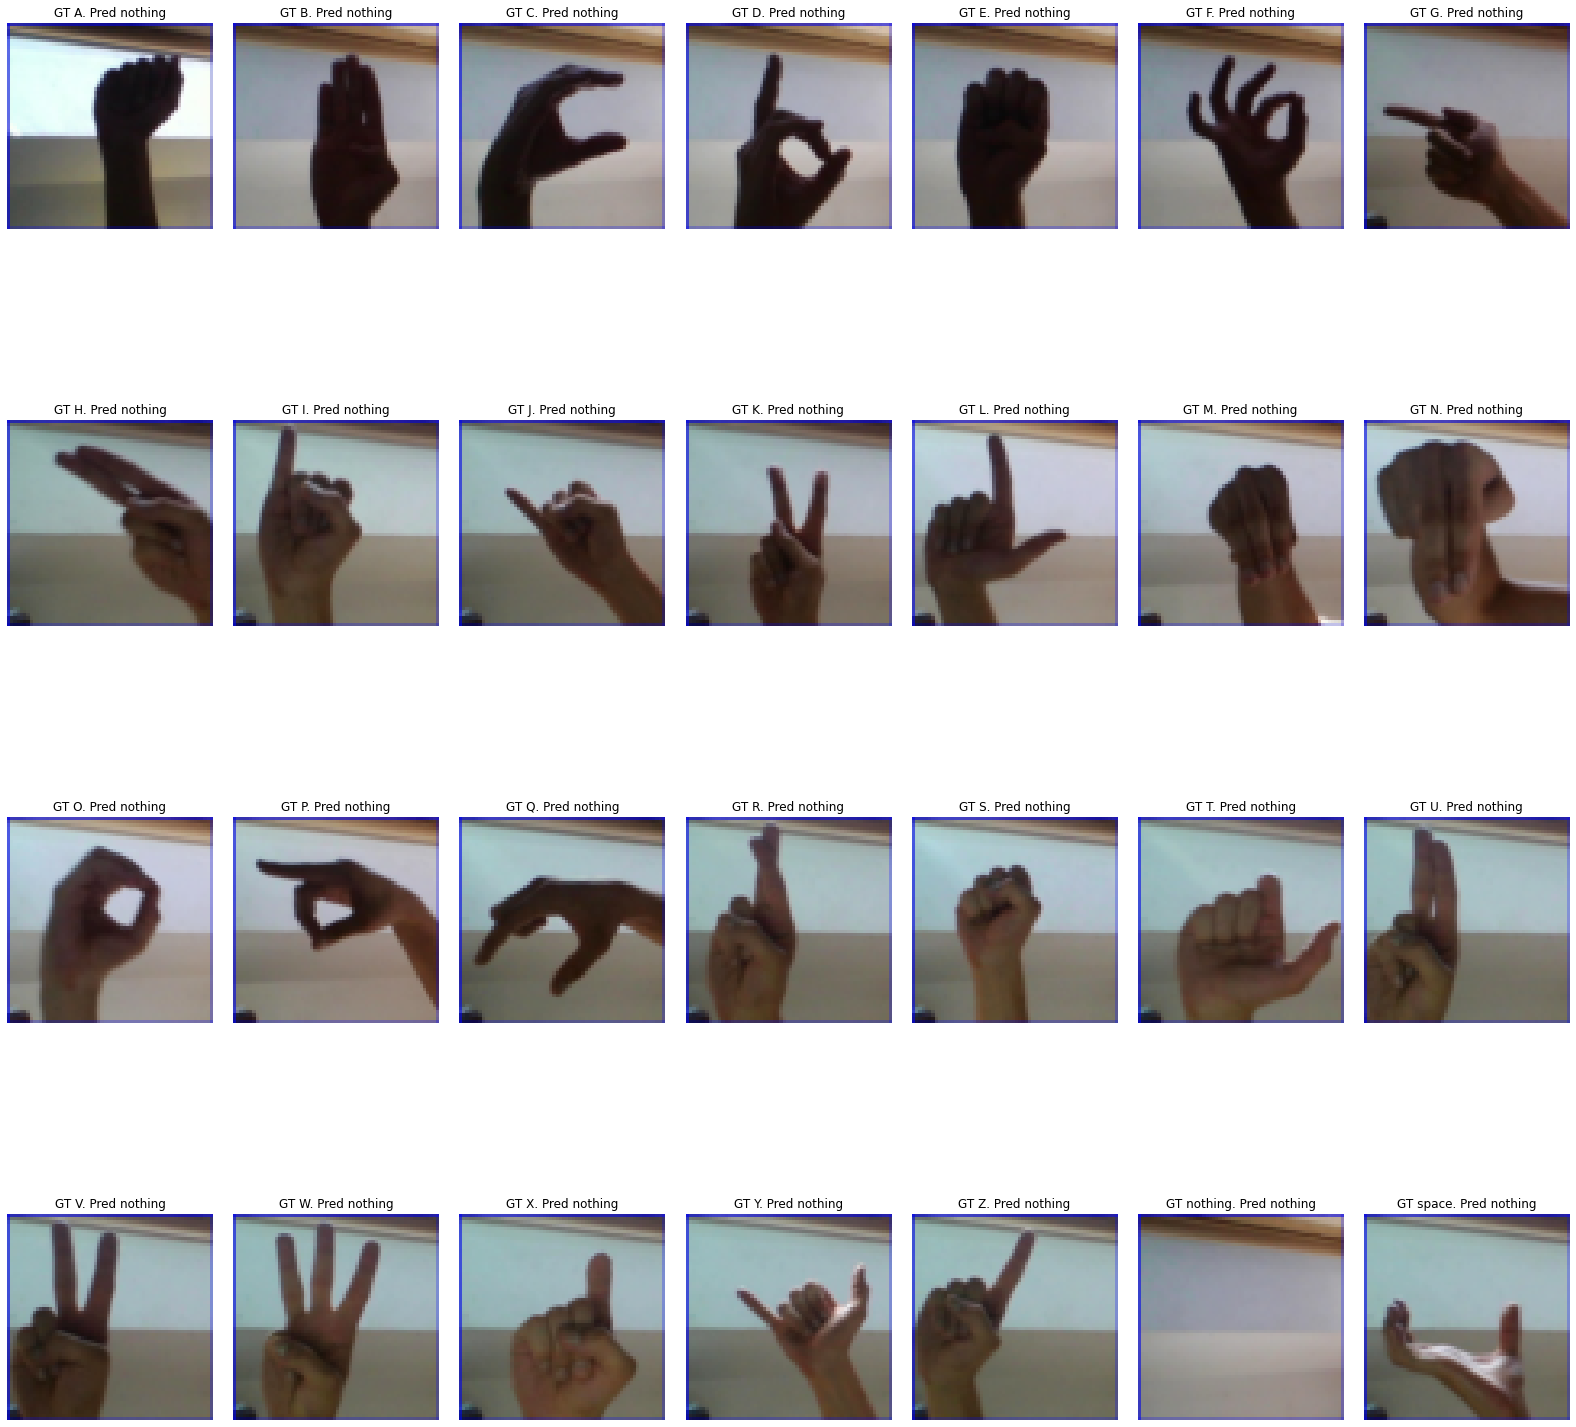

In [ ]:
test_dataset = ASLTestDataset(test_data_path, transforms=test_transforms)

columns = 7
row = round(len(test_dataset) / columns)

fig, ax = plt.subplots(row, columns, figsize=(columns * row, row * columns))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

i, j = 0, 0
for img, label in test_dataset:
    img = torch.Tensor(img)
    img = img.to(device)
    model.eval()
    prediction = model(img[None])

    ax[i][j].imshow(img.cpu().permute(1, 2, 0))
    ax[i][j].set_title(f'GT {label}. Pred {classes[torch.max(prediction, dim=1)[1]]}')
    ax[i][j].axis('off')
    j += 1
    if j == columns:
        j = 0
        i += 1

plt.show()

7

0

0